In [1]:
import numpy as np
from itertools import cycle



In [2]:
x_cons_data= np.load('../high_psi dataset/x_cons_data.npy')

hx_cas_data= np.load('../high_psi dataset/x_cas_data.npy')
lx_cas_data= np.load('../low_psi_data/x_cas_data.npy')


In [3]:
x_cons_data.shape,hx_cas_data.shape,lx_cas_data.shape

((39128, 283, 5), (4952, 283, 5), (6838, 283, 5))

In [4]:
auccc=np.zeros((10,10))

In [5]:
def cross_split(x_cons_data,hx_cas_data,lxcase_data,s):
    
    a=int(x_cons_data.shape[0]/10)
    b=int(hx_cas_data.shape[0]/10)
    c=int(lx_cas_data.shape[0]/10)
    
    #9 folds for training
    train=x_cons_data[:a*s]
    train=np.concatenate((train,x_cons_data[a*(s+1):]),axis=0)

    d=int((9*a)/(9*(b+c)))
    print(d)
    for i in range (d):
        train=np.concatenate((train,hx_cas_data[:b*s]),axis=0)
        train=np.concatenate((train,hx_cas_data[b*(s+1):]),axis=0)
    
        train=np.concatenate((train,lx_cas_data[:c*s]),axis=0)
        train=np.concatenate((train,lx_cas_data[c*(s+1):]),axis=0)
      
    np.random.shuffle(train)
    np.random.shuffle(train)
    
    # 1 fold for testing
    
    htest=np.concatenate((hx_cas_data[b*s:b*(s+1)],x_cons_data[a*s:a*(s+1)]),axis=0)
    lt=   np.concatenate((lx_cas_data[c*s:c*(s+1)],x_cons_data[a*s:a*(s+1)]),axis=0)

    test=htest
    test=np.concatenate((test,lx_cas_data[c*s:c*(s+1)]),axis=0)
    
    cons_test=x_cons_data[a*s:a*(s+1)]
    cas_test=np.concatenate((lx_cas_data[c*s:c*(s+1)],hx_cas_data[b*s:b*(s+1)]))
                          
    return train,test,htest,lt,cons_test,cas_test


In [6]:
l=141

In [7]:
train,test,htest,ltest,cons,cas=cross_split(x_cons_data,hx_cas_data,lx_cas_data,0)

y_train=train[:,l-1,0]
y_test=test[:,l-1,0]
hy_test=htest[:,l-1,0]
ly_test=ltest[:,l-1,0]

train.shape,test.shape,htest.shape

3


((67052, 283, 5), (5090, 283, 5), (4407, 283, 5))

In [8]:
def evaluate_AUC2():
    psi=cas[:,-1,4]
    roc_auc=np.zeros(5)
    colors = cycle(['black','green','red','orange','blue'])
    f=plt.figure()

    
    for i, color in zip(range(5), colors):
    
        
        ptest=cas[ (psi >=i*2*0.1) & (psi< (i+1)*2*0.1)  ]
        ptest=np.concatenate((ptest,cons),axis=0)
        py_test=ptest[:,l-1,0]

        ypreds=model.predict([ptest[:,:l-1,:4],ptest[:,l:(l*2)-1,:4],ptest[:,-1,0:3]])
        fpr, tpr, thresholds = roc_curve(py_test, ypreds)
        roc_auc[i] = auc(fpr, tpr)
        lw=2

        plt.plot(fpr, tpr, color=color, lw=lw,
                 label='Inclusion level %d-%d %% (AUC= %0.2f)' % (i*2*10,(i+1)*2*10,roc_auc[i]))
        
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    f.savefig("../plots/cas2.pdf", bbox_inches='tight')
    plt.show()
    
    roc_auc=np.zeros(10)

    for i in range(10):
            ptest=cas[(psi >=i*0.1) & (psi< (i+1)*0.1)]
            ptest=np.concatenate((ptest,cons),axis=0)
            py_test=ptest[:,l-1,0]

            ypreds=model.predict([ptest[:,:l-1,:4],ptest[:,l:(l*2)-1,:4],ptest[:,-1,0:3]])
            fpr, tpr, thresholds = roc_curve(py_test, ypreds)
            roc_auc[i] = auc(fpr, tpr)

    
    return roc_auc


In [9]:

def evaluate_AUC():
    ypreds=model.predict([htest[:,:l-1,:4],htest[:,l:(l*2)-1,:4],htest[:,-1,0:3]])
    fpr, tpr, thresholds = roc_curve(hy_test, ypreds)
    roc_auc = auc(fpr, tpr)
    
    ypreds2=model.predict([test[:,:l-1,:4],test[:,l:(l*2)-1,:4],test[:,-1,0:3]])
    fpr2, tpr2, thresholds2 = roc_curve(y_test, ypreds2)
    roc_auc2 = auc(fpr2, tpr2)
    
    ypreds3=model.predict([ltest[:,:l-1,:4],ltest[:,l:(l*2)-1,:4],ltest[:,-1,0:3]])
    fpr3, tpr3, thresholds3 = roc_curve(ly_test, ypreds3)
    roc_auc3 = auc(fpr3, tpr3)
    

    lw=2
    
    
    
    f=plt.figure()
    plt.plot(fpr2, tpr2, color='orange', lw=1, label=    'All ES events (AUC= %0.2f)' % roc_auc2)
    
    plt.plot(fpr, tpr, color='red', lw=1,          label='HEvents ES subset (AUC= %0.2f)' % roc_auc)
    
    plt.plot(fpr3, tpr3, color='navy', lw=1,       label='MREvents ES subset (AUC= %0.2f)' % roc_auc3)

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
    f.savefig("../plots/cas.pdf", bbox_inches='tight')

    plt.show()


    return

In [10]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [11]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras import optimizers
from keras.layers import Input, BatchNormalization
from keras.models import Model
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.keras import layers

Using TensorFlow backend.


In [12]:
from keras import regularizers

In [13]:
from keras import regularizers
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from keras import initializers
from keras.layers import Activation, Dense, Add

In [16]:
aucc=np.zeros((10,3))

In [14]:
inputs1 = Input(shape=(l-1, 4))
inputs2 = Input(shape=(l-1, 4))
inputs3 = Input(shape=(3,))


x=Conv1D(filters=32,kernel_size=7,strides=1,kernel_initializer=initializers.random_uniform()) (inputs1)
x=Dropout(0.2)(x)
x=Activation('relu')(x)
x=MaxPooling1D(pool_size=2, strides=2)(x)

x=Conv1D(filters=8,kernel_size=4,strides=1,kernel_initializer=initializers.random_uniform()) (x)
x=Dropout(0.2)(x)
x=Activation('relu')(x)
x=MaxPooling1D(pool_size=2, strides=2)(x)


x=Conv1D(filters=8,kernel_size=3,strides=1,kernel_initializer=initializers.random_uniform()) (x)
x=Dropout(0.2)(x)
x=Activation('relu')(x)
x=MaxPooling1D(pool_size=2, strides=2)(x)


xx=Conv1D(filters=32,kernel_size=7,strides=1,kernel_initializer=initializers.random_uniform()) (inputs2)
xx=Dropout(0.2)(xx)
xx=Activation('relu')(xx)
xx=MaxPooling1D(pool_size=2, strides=2)(xx)

xx=Conv1D(filters=8,kernel_size=4,strides=1,kernel_initializer=initializers.random_uniform()) (xx)
xx=Dropout(0.2)(xx)
xx=Activation('relu')(xx)
xx=MaxPooling1D(pool_size=2, strides=2)(xx)


xx=Conv1D(filters=8,kernel_size=3,strides=1,kernel_initializer=initializers.random_uniform()) (xx)
xx=Dropout(0.2)(xx)
xx=Activation('relu')(xx)
xx=MaxPooling1D(pool_size=2, strides=2)(xx)


x2=keras.layers.concatenate([xx,x])



x2=Flatten()(x2)


x2=keras.layers.concatenate([x2,inputs3],axis=1)





x3=Dense(64, activation='relu',)(x2)
x3=Dropout(0.5)(x3)


x3=Dense(1, activation='sigmoid',  )(x3)


model = Model(inputs=[inputs1,inputs2,inputs3], outputs=x3)




model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=0.0005,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08,
                                        decay=0.0),metrics=['accuracy'])



print (model.summary())
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_w2.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 140, 4)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 140, 4)       0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 134, 32)      928         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 134, 32)      928         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_4 

In [15]:
for i in range (50):
    

    
    print('epoch :',i)
    model.fit([train[:,:l-1,:4],train[:,l:(l*2)-1,:4],train[:,-1,0:3]], y_train,validation_data=([test[:,:l-1,:4],test[:,l:(l*2)-1,:4],test[:,-1,0:3]], y_test), epochs = 1, verbose = 1, batch_size = 256)
    y_=model.predict([htest[:,:l-1,:4],htest[:,l:(l*2)-1,:4],htest[:,-1,0:3]])
    print("AUC under ROC for high inclusion exons:",roc_auc_score(hy_test, y_))
    

epoch : 0
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 11s 167us/step - loss: 0.6837 - acc: 0.5623 - val_loss: 0.6415 - val_acc: 0.7122
AUC under ROC for high inclusion exons: 0.5673728594740864
epoch : 1
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 4s 53us/step - loss: 0.6646 - acc: 0.6112 - val_loss: 0.6150 - val_acc: 0.7297
AUC under ROC for high inclusion exons: 0.5877628534837123
epoch : 2
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 50us/step - loss: 0.6417 - acc: 0.6404 - val_loss: 0.6072 - val_acc: 0.6963
AUC under ROC for high inclusion exons: 0.6079731362706823
epoch : 3
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 4s 53us/step - loss: 0.6216 - acc: 0.6588 - val_loss: 0.5887 - val_acc: 0.7100
AUC under ROC for high inclusion exons: 0

67052/67052 [==============================] - 3s 49us/step - loss: 0.4116 - acc: 0.8150 - val_loss: 0.4540 - val_acc: 0.7969
AUC under ROC for high inclusion exons: 0.813929685402078
epoch : 33
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 4s 54us/step - loss: 0.4095 - acc: 0.8165 - val_loss: 0.4746 - val_acc: 0.7833
AUC under ROC for high inclusion exons: 0.8076787816818491
epoch : 34
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 51us/step - loss: 0.4055 - acc: 0.8196 - val_loss: 0.4297 - val_acc: 0.8108
AUC under ROC for high inclusion exons: 0.8104751502757637
epoch : 35
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 52us/step - loss: 0.4045 - acc: 0.8182 - val_loss: 0.4908 - val_acc: 0.7717
AUC under ROC for high inclusion exons: 0.8136133833219722
epoch : 36
Train on 67052 samples, validate on 5090

In [16]:
for i in range (50):
    

    
    print('epoch :',i)
    model.fit([train[:,:l-1,:4],train[:,l:(l*2)-1,:4],train[:,-1,0:3]], y_train,validation_data=([test[:,:l-1,:4],test[:,l:(l*2)-1,:4],test[:,-1,0:3]], y_test), epochs = 1, verbose = 1, batch_size = 256)
    y_=model.predict([htest[:,:l-1,:4],htest[:,l:(l*2)-1,:4],htest[:,-1,0:3]])
    print("AUC under ROC for high inclusion exons:",roc_auc_score(hy_test, y_))

epoch : 0
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 50us/step - loss: 0.3809 - acc: 0.8293 - val_loss: 0.4695 - val_acc: 0.7886
AUC under ROC for high inclusion exons: 0.8117883848712071
epoch : 1
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 51us/step - loss: 0.3790 - acc: 0.8305 - val_loss: 0.4219 - val_acc: 0.8179
AUC under ROC for high inclusion exons: 0.8170371919605048
epoch : 2
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 4s 54us/step - loss: 0.3789 - acc: 0.8301 - val_loss: 0.4764 - val_acc: 0.7837
AUC under ROC for high inclusion exons: 0.8074476875090372
epoch : 3
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 4s 53us/step - loss: 0.3776 - acc: 0.8307 - val_loss: 0.3936 - val_acc: 0.8393
AUC under ROC for high inclusion exons: 0.8

67052/67052 [==============================] - 3s 52us/step - loss: 0.3575 - acc: 0.8383 - val_loss: 0.4035 - val_acc: 0.8267
AUC under ROC for high inclusion exons: 0.8288601764061887
epoch : 33
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 50us/step - loss: 0.3563 - acc: 0.8410 - val_loss: 0.4244 - val_acc: 0.8138
AUC under ROC for high inclusion exons: 0.8270705521472393
epoch : 34
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 52us/step - loss: 0.3549 - acc: 0.8408 - val_loss: 0.4488 - val_acc: 0.8002
AUC under ROC for high inclusion exons: 0.8196887071120199
epoch : 35
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 50us/step - loss: 0.3549 - acc: 0.8393 - val_loss: 0.4703 - val_acc: 0.7941
AUC under ROC for high inclusion exons: 0.8115356014129019
epoch : 36
Train on 67052 samples, validate on 509

In [17]:
for i in range (100):
    

    
    print('epoch :',i)
    model.fit([train[:,:l-1,:4],train[:,l:(l*2)-1,:4],train[:,-1,0:3]], y_train,validation_data=([test[:,:l-1,:4],test[:,l:(l*2)-1,:4],test[:,-1,0:3]], y_test), epochs = 1, verbose = 1, batch_size = 256)
    y_=model.predict([htest[:,:l-1,:4],htest[:,l:(l*2)-1,:4],htest[:,-1,0:3]])
    print("AUC under ROC for high inclusion exons:",roc_auc_score(hy_test, y_))

epoch : 0
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 49us/step - loss: 0.3487 - acc: 0.8440 - val_loss: 0.4225 - val_acc: 0.8177
AUC under ROC for high inclusion exons: 0.8211065150482328
epoch : 1
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 51us/step - loss: 0.3492 - acc: 0.8429 - val_loss: 0.3702 - val_acc: 0.8530
AUC under ROC for high inclusion exons: 0.8344061783478961
epoch : 2
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 4s 53us/step - loss: 0.3452 - acc: 0.8458 - val_loss: 0.3966 - val_acc: 0.8371
AUC under ROC for high inclusion exons: 0.8263165912705791
epoch : 3
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 48us/step - loss: 0.3492 - acc: 0.8439 - val_loss: 0.4282 - val_acc: 0.8214
AUC under ROC for high inclusion exons: 0.8

67052/67052 [==============================] - 3s 52us/step - loss: 0.3387 - acc: 0.8469 - val_loss: 0.3790 - val_acc: 0.8493
AUC under ROC for high inclusion exons: 0.8354547520191693
epoch : 33
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 51us/step - loss: 0.3397 - acc: 0.8477 - val_loss: 0.3876 - val_acc: 0.8440
AUC under ROC for high inclusion exons: 0.8300210695916217
epoch : 34
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 49us/step - loss: 0.3390 - acc: 0.8495 - val_loss: 0.3858 - val_acc: 0.8436
AUC under ROC for high inclusion exons: 0.834612484765859
epoch : 35
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 4s 53us/step - loss: 0.3380 - acc: 0.8499 - val_loss: 0.3773 - val_acc: 0.8523
AUC under ROC for high inclusion exons: 0.8323087727995703
epoch : 36
Train on 67052 samples, validate on 5090

67052/67052 [==============================] - 3s 48us/step - loss: 0.3308 - acc: 0.8531 - val_loss: 0.3421 - val_acc: 0.8709
AUC under ROC for high inclusion exons: 0.8502628534837123
epoch : 65
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 48us/step - loss: 0.3324 - acc: 0.8525 - val_loss: 0.3408 - val_acc: 0.8754
AUC under ROC for high inclusion exons: 0.8427836648695545
epoch : 66
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 47us/step - loss: 0.3327 - acc: 0.8507 - val_loss: 0.3369 - val_acc: 0.8772
AUC under ROC for high inclusion exons: 0.850643448802958
epoch : 67
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 50us/step - loss: 0.3322 - acc: 0.8527 - val_loss: 0.3517 - val_acc: 0.8650
AUC under ROC for high inclusion exons: 0.8436873850984281
epoch : 68
Train on 67052 samples, validate on 5090

67052/67052 [==============================] - 4s 54us/step - loss: 0.3284 - acc: 0.8538 - val_loss: 0.3370 - val_acc: 0.8774
AUC under ROC for high inclusion exons: 0.8498838073991449
epoch : 97
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 49us/step - loss: 0.3285 - acc: 0.8542 - val_loss: 0.3289 - val_acc: 0.8817
AUC under ROC for high inclusion exons: 0.8505763153002417
epoch : 98
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 3s 51us/step - loss: 0.3275 - acc: 0.8545 - val_loss: 0.3213 - val_acc: 0.8886
AUC under ROC for high inclusion exons: 0.850736402883642
epoch : 99
Train on 67052 samples, validate on 5090 samples
Epoch 1/1
67052/67052 [==============================] - 4s 53us/step - loss: 0.3267 - acc: 0.8551 - val_loss: 0.3280 - val_acc: 0.8833
AUC under ROC for high inclusion exons: 0.8543326929829997


In [18]:


y1_=model.predict([htest[:,:l-1,:4],htest[:,l:(l*2)-1,:4],htest[:,-1,0:3]])
ac1 = roc_auc_score(hy_test, y1_)

y2_=model.predict([ltest[:,:l-1,:4],ltest[:,l:(l*2)-1,:4],ltest[:,-1,0:3]])
ac3 = roc_auc_score(ly_test, y2_)

y_=model.predict([test[:,:l-1,:4],test[:,l:(l*2)-1,:4],test[:,-1,0:3]])
ac2 = roc_auc_score(y_test, y_)
ac1,ac3,ac2

(0.8543326929829997, 0.9221897109767746, 0.8936759385600357)

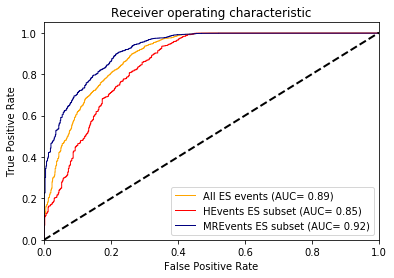

In [19]:
evaluate_AUC()

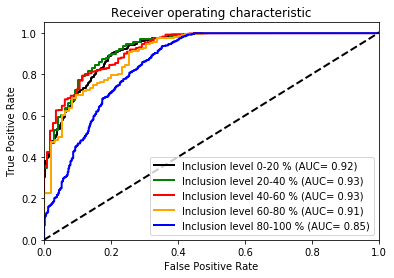

array([0.92354215, 0.92316938, 0.93189952, 0.9263425 , 0.94484614,
       0.9219014 , 0.88352273, 0.9243855 , 0.86013393, 0.85121588])

In [21]:
evaluate_AUC2()